# **Deep Neural Networks to Better Analyze FAANG Securities**
---

### Import Libraries

In [3]:
import os
import warnings

import pandas as pd
import seaborn as sns
import numpy as np

from importlib import reload
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 227

warnings.filterwarnings('ignore')

### Import ARIMA, SARIMA Libraries

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

### Import Tensorflow Keras Libraries 

In [5]:
import tensorflow.keras as keras

from tensorflow.python.keras.optimizer_v2 import rmsprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Bidirectional, Dropout, ConvLSTM2D, GlobalMaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model

# Tensorflow Keras Libraries Used
# LSTM Network - Sequential
from tensorflow.keras.layers import LSTM, Dense
# Convolution Network and Bayesian Optimization - Sequential 
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D



from bayes_opt import BayesianOptimization
from functools import partial 

In [6]:
np.random.seed(66)

### Import Data

In [7]:
ticker = 'FB'
#ticker = 'AAPL'
#ticker = 'AMZN'
#ticker = 'NFLX'
#ticker = 'GOOG'

# Colors
lightblue = '#4ac2fb'
pinkyred = '#ff4e97'
black='#333333'

In [8]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)
print(files)

['amzn.csv', 'fb.csv', 'nflx.csv', 'goog.csv', 'aapl.csv']


### Prepare Data

In [10]:
def scale(dataframe, scale=(0,1)):
    # Scale Features to [0-1]
    columns = dataframe.columns 
    scaler = MinMaxScaler()
    scaler.feature_range = scale 
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=columns)

In [11]:
n_steps = 21

scaled_ticker = scale(stocks[ticker.lower()], scale=(0,1))
# print(scaled_ticker)
scaled_ticker.isna().sum()

High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
Return         0
Change         0
Volatility     1
MA7            6
MA21          20
Momentum       3
RSI           14
MACD           0
Signal         0
Upper_Band    20
Lower_Band    20
dtype: int64

In [12]:
scaled_ticker.dropna(inplace=True)

In [13]:
print('No Missing Data') if sum(scaled_ticker.isna().sum())==0 else scaled_ticker.isna().sum()

No Missing Data


### Split Multivariate Sequence into Samples 

In [14]:
def split_multivariate(features, target, n_steps, split=True, ratio=0.8):
    
    X, y = [], []
    for i in range(len(features)):
        end_index = i + n_steps
        if end_index > len(features):
            break
        seq_x, seq_y = features[i:end_index], target[end_index-1]
        X.append(seq_x)
        y.append(seq_y)
        
    if split == True:
        X_train = np.array(X[:round(len(X)*ratio)])
        y_train = np.array(y[:round(len(X)*ratio)])
        X_test = np.array(X[round(len(X)*ratio):])
        y_test = np.array(y[round(len(X)*ratio):])
        
        return X_train, y_train, X_test, y_test
    else:
        return np.array(X), np.array(y)

In [17]:
X_train, \
y_train, \
X_test, \
y_test = split_multivariate(scaled_ticker.to_numpy()[:-1],
                         stocks[ticker.lower()].Return.shift(-1).to_numpy()[:-1],
                         n_steps,
                         split=True,
                         ratio=0.8)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1958, 21, 17)
y_train shape: (1958,)
X_test shape: (490, 21, 17)
y_test shape: (490,)


---
# LSTM Network: Training Process
---

In [18]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

print(f"Steps: {n_steps}")
print(f"Features: {n_features}")

Steps: 21
Features: 17


In [24]:
model = Sequential(name="LSTM_Network_Sequential_Model")

# can pass `Input()` to predefine the shape of the model in it's own line
# model.add(Input(shape=(n_steps,n_features)))
# model.add(LSTM(100, activation='relu', return_sequences=True))

# or you can pass it into the first layer 
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [25]:
# Layer Weight and Biases 
num_layers = len(model.layers)

layers_weights = {}
layers_biases = {}
for i in range(num_layers):
    layers_weights[i] = model.layers[i].get_weights()[0]
    layers_biases[i] = model.layers[i].get_weights()[1]

print(f"Layers of the Sequential Model: {num_layers}")
print(f" Bias defined when layer is called to be added to model")
print(f" Layer 1: (Weight: {len(layers_weights[0])}, Bias: {len(layers_biases[0])})")
print(f" Layer 2: (Weight: {len(layers_weights[1])}, Bias: {len(layers_biases[1])})")
print(f" Layer 3: (Weight: {len(layers_weights[2])}, Bias: {len(layers_biases[2])})")
print(f" Layer 4: (Weight: {len(layers_weights[3])}, Bias: {len(layers_biases[3])})")

Layers of the Sequential Model: 4
 Bias defined when layer is called to be added to model
 Layer 1: (Weight: 17, Bias: 100)
 Layer 2: (Weight: 100, Bias: 50)
 Layer 3: (Weight: 50, Bias: 10)
 Layer 4: (Weight: 10, Bias: 1)


In [26]:
print(model.summary())

Model: "LSTM_Network_Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 21, 100)           47200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 77,921
Trainable params: 77,921
Non-trainable params: 0
_________________________________________________________________
None


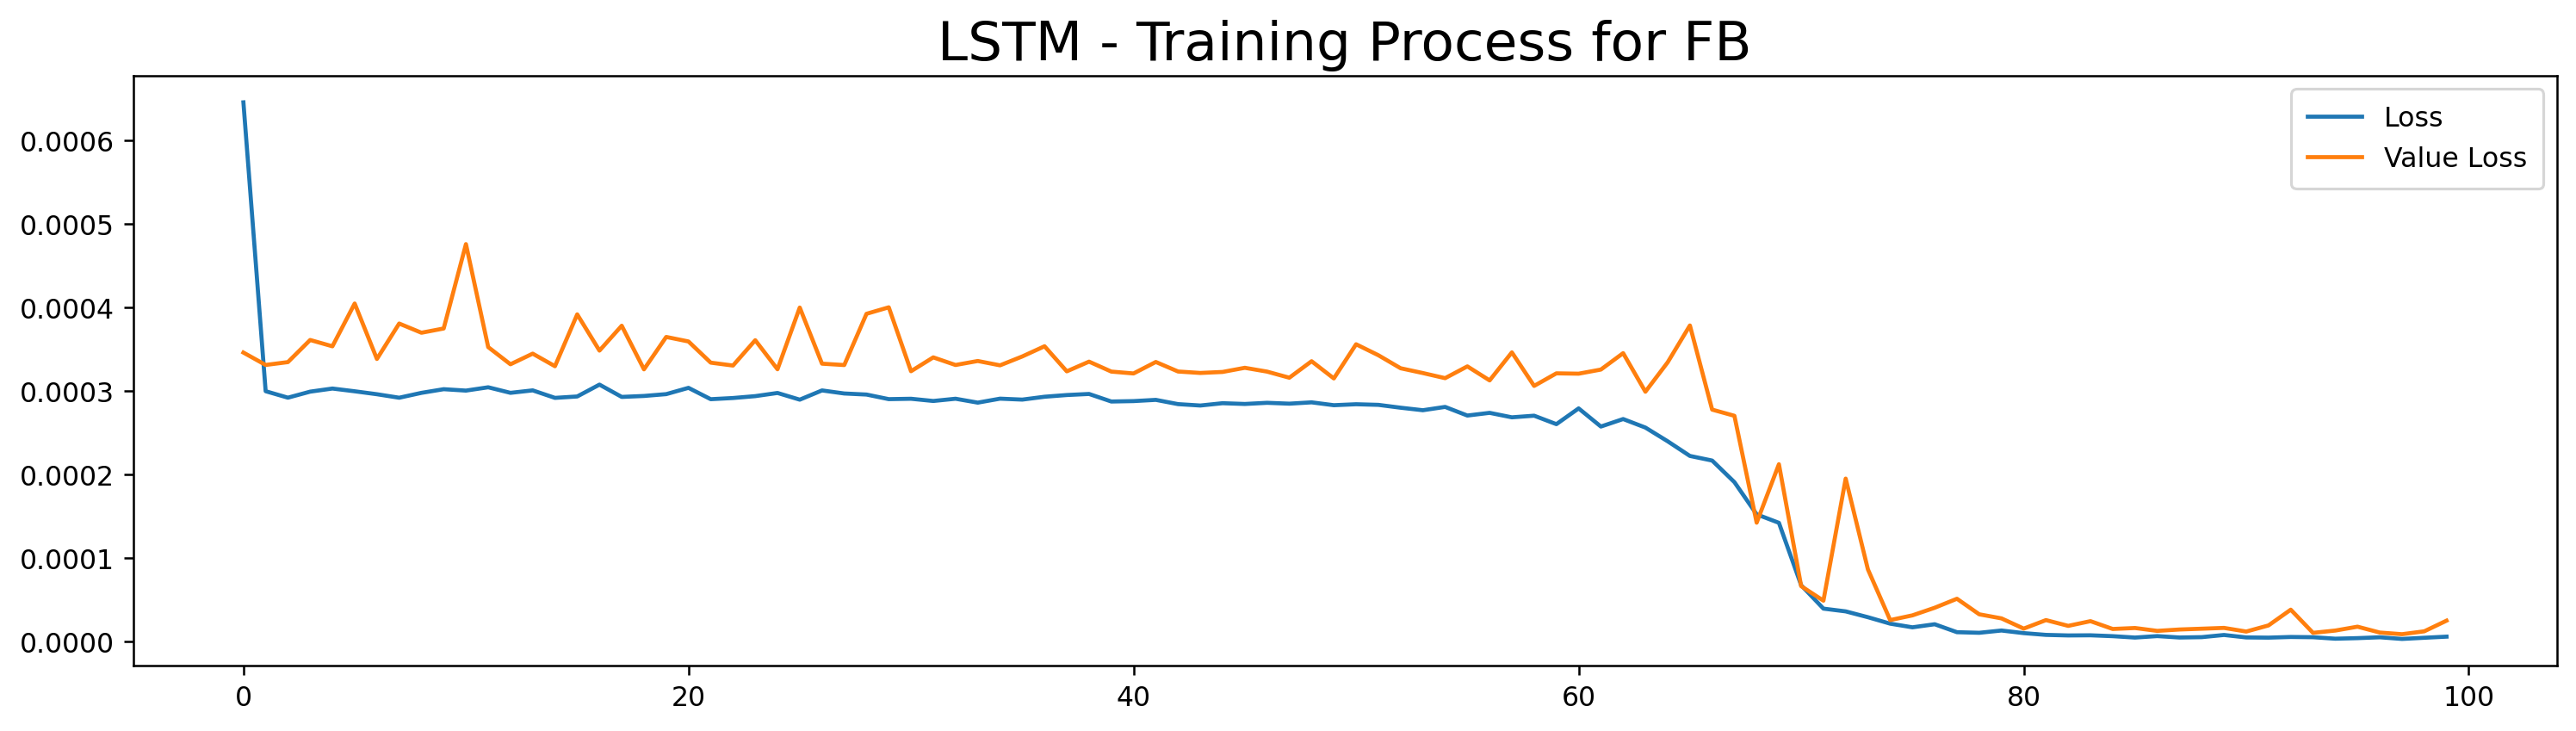

In [27]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1, borderpad=.6)
plt.title(f"LSTM - Training Process for {ticker.upper()}", fontsize=20)
plt.show()

---
# LSTM Network: Daily Return Prediction
---

In [32]:
def MLevaluation(X, y, model, n_preds=10, random=True, show_graph=True): 
    
    n_steps = X.shape[1]
    max_random_int = len(y) - n_steps 
    y_true, y_pred = [], []
    prediction_accuracy, slices = [],[]
    
    for i in range(n_preds): 
        if random == True: 
            position = np.random.randint(0, max_random_int)
        else: 
            position = i 
        
        y_hat = model.predict(X[position:position+1])[0][0]
        y_pred.append(y_hat)
        y_true.append(y[position])
        y_current = y[position]
        
        
        
        # if correctly predics return c=0
        # else: c= previous sequence position 
        if y.min() < 0: c = 0 
        else: c = y[position-1]
            
        if ((y_hat > c) & (y_current > c)) or ((y_hat < c) & (y_current < c)): 
                acc = 1
        else: 
            acc = 0 
              
            
        prediction_accuracy.append(acc)
        slices.append((list(y[position - n_steps:position + 1]), 
                      list(y[position - n_steps: position]) + [y_hat], 
                      acc))
        
        
    if show_graph == True: 
        plt.rcParams['figure.dpi'] = 227
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(18,5))
        
        plt.bar(range(n_preds), y_true[:], width=.7, alpha=.6, color=lightblue, label="True")
        plt.bar(range(n_preds), y_pred[:], width=.7, alpha=.6, color=pinkyred, label="Predicted")
        plt.axhline(0, color=black, lw=.8)
        
        plt.legend(frameon=True, loc=1, borderpad=.6)
        plt.title(f"Daily Return Prediction for {ticker.upper()}", fontsize=20)
        plt.show()
    
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Accuracy: {round((sum(prediction_accuracy)/len(prediction_accuracy) * 100),2)}%")
    return slices, np.array(y_true), np.array(y_pred)
        

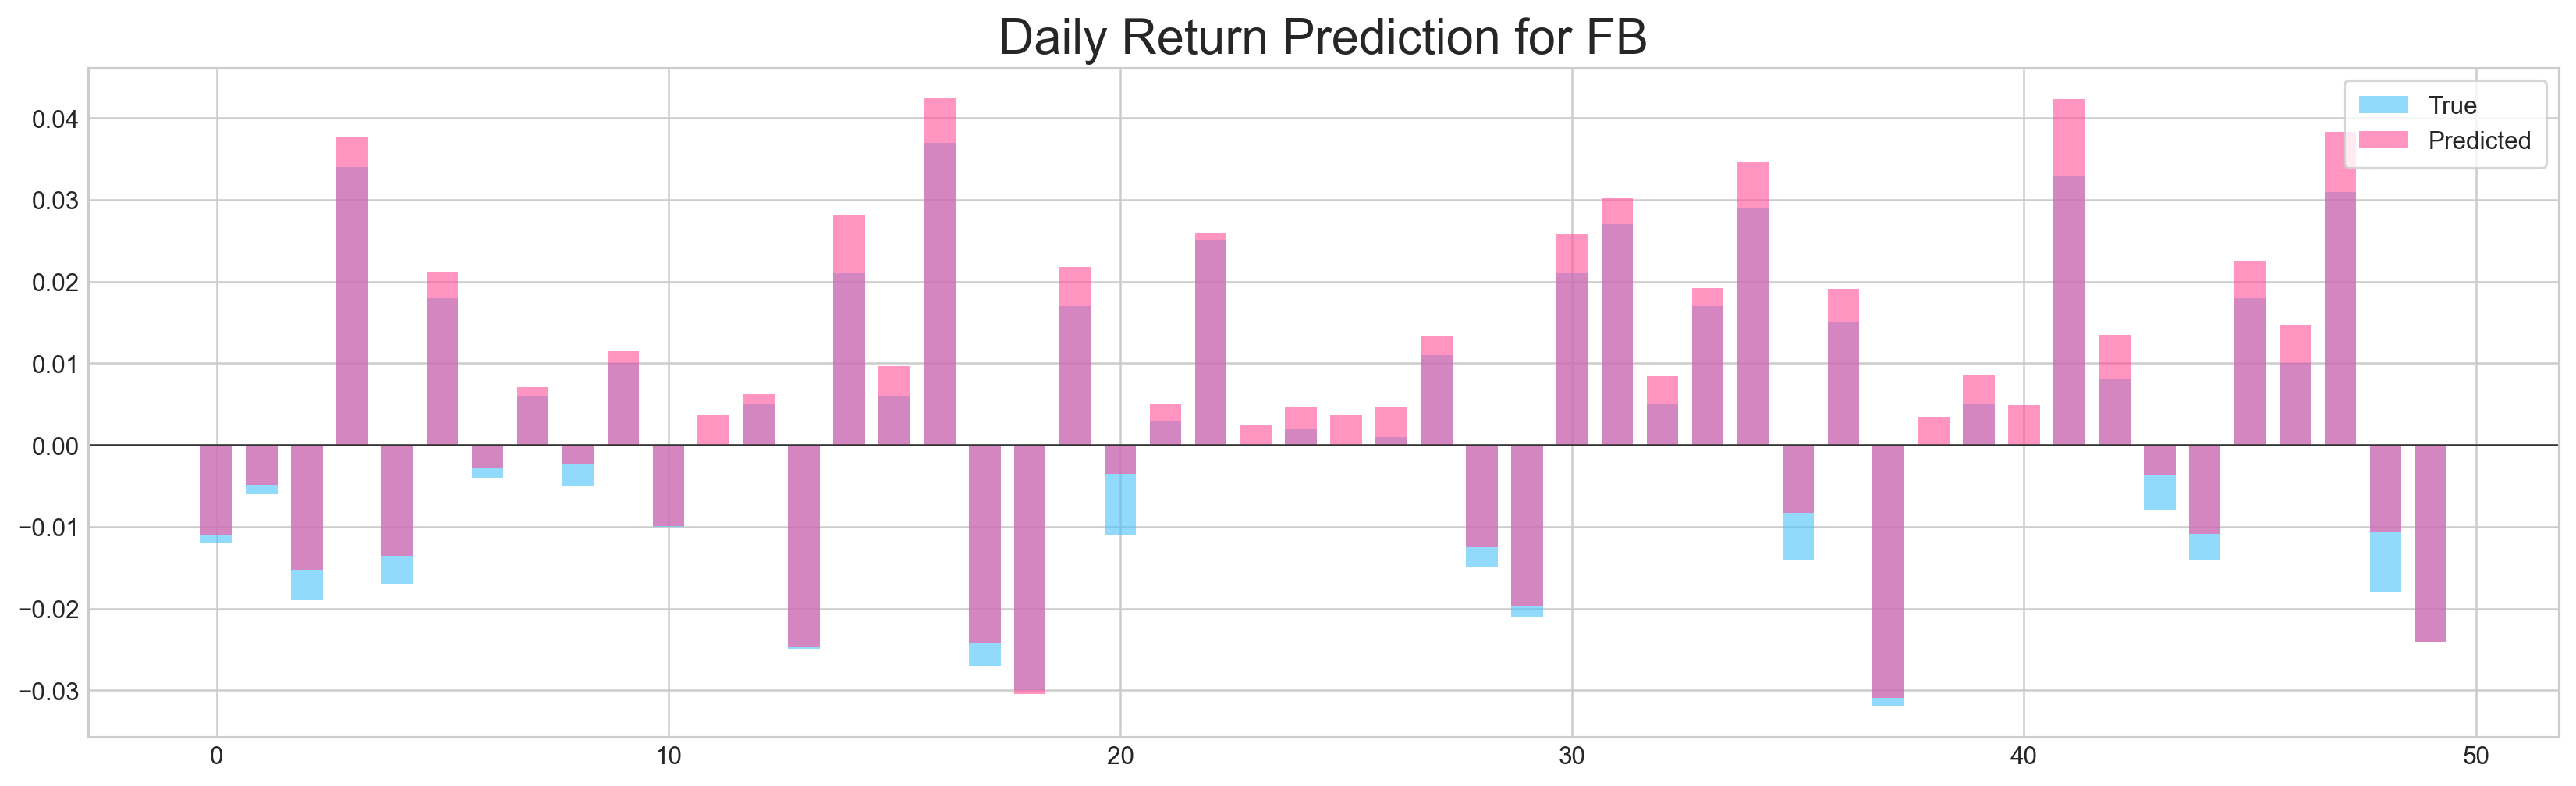

MSE: 1.588581655545079e-05
Accuracy: 90.0%


In [33]:
pred, y_true, y_pred = MLevaluation(X_test, y_test, model, random=False, n_preds=50, show_graph=True)

---
# Convolutional Network: Training Process
---

In [37]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential() 

model.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 20)            700       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 20)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
______________________________________________________

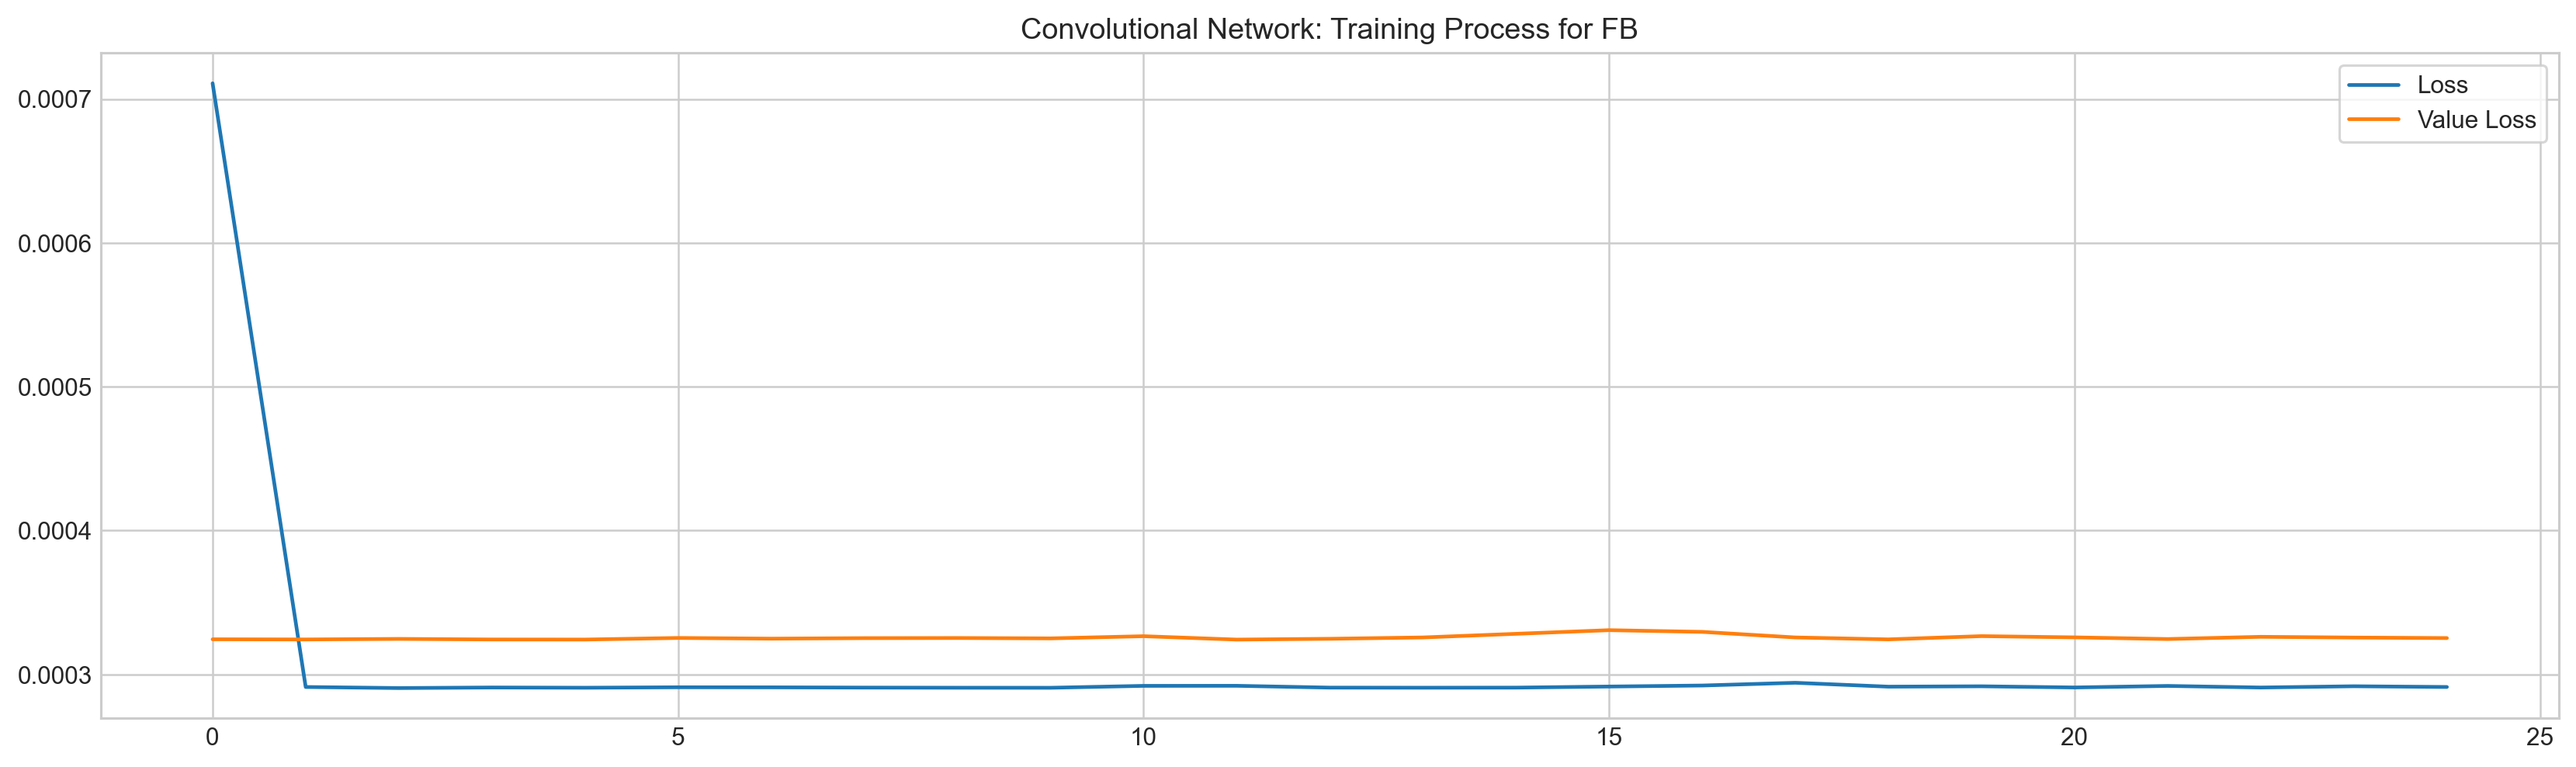

In [39]:
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1)
plt.title('Convolutional Network: Training Process for '+ticker.upper())
plt.show()

---
# Convolutional Network: Daily Return Prediction 
---

In [40]:
def evaluation(X, y, model, n_preds=10, random=True, show_graph=True):
    
    n_steps = X.shape[1]
    max_random_int = len(y) - n_steps
    
    y_true, y_pred = [], []
    pred_accuracy, slices = [], []
    
    for i in range(n_preds):
        if random == True: 
            position = np.random.randint(0, max_random_int)
        else:
            position = i 
            
        y_hat = model.predict(X[position:position+1])[0][0]
        y_pred.append(y_hat)
        y_true.append(y[position])
        y_current = y[position]
        
        if y.min() < 0:
            c = 0 
        else: 
            c = y[position-1]
        
        if ((y_hat > c) & (y_current > c)) or ((y_hat < c) & (y_current < c)): 
            acc = 1
        else:
            acc = 0 
            
        pred_accuracy.append(acc)
        slices.append((list(y[position-n_steps : position+1]) + [y_hat], acc))
    
    if show_graph == True:
        plt.rcParams['figure.dpi']=227
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(18,5))
        
        plt.bar(range(n_preds), y_true[:], width=.7, alpha=.6, color=lightblue, label="True")
        plt.bar(range(n_preds), y_pred[:], width=.7, alpha=.6, color=pinkyred, label="Predicted")
        
        plt.axhline(0,color=black,lw=.8)
        plt.legend(frameon=True, loc=1, borderpad=.6)
        plt.title('Convolution Network: Daily Return Prediction for '+ticker.upper(), fontsize=20)
        plt.show()
    
    print('MSE: ', mean_squared_error(y_true,y_pred))
    print('Accuracy: {}%'.format(round((sum(pred_accuracy)/len(pred_accuracy))*100, 2)))
    return slices, np.array(y_true), np.array(y_pred)

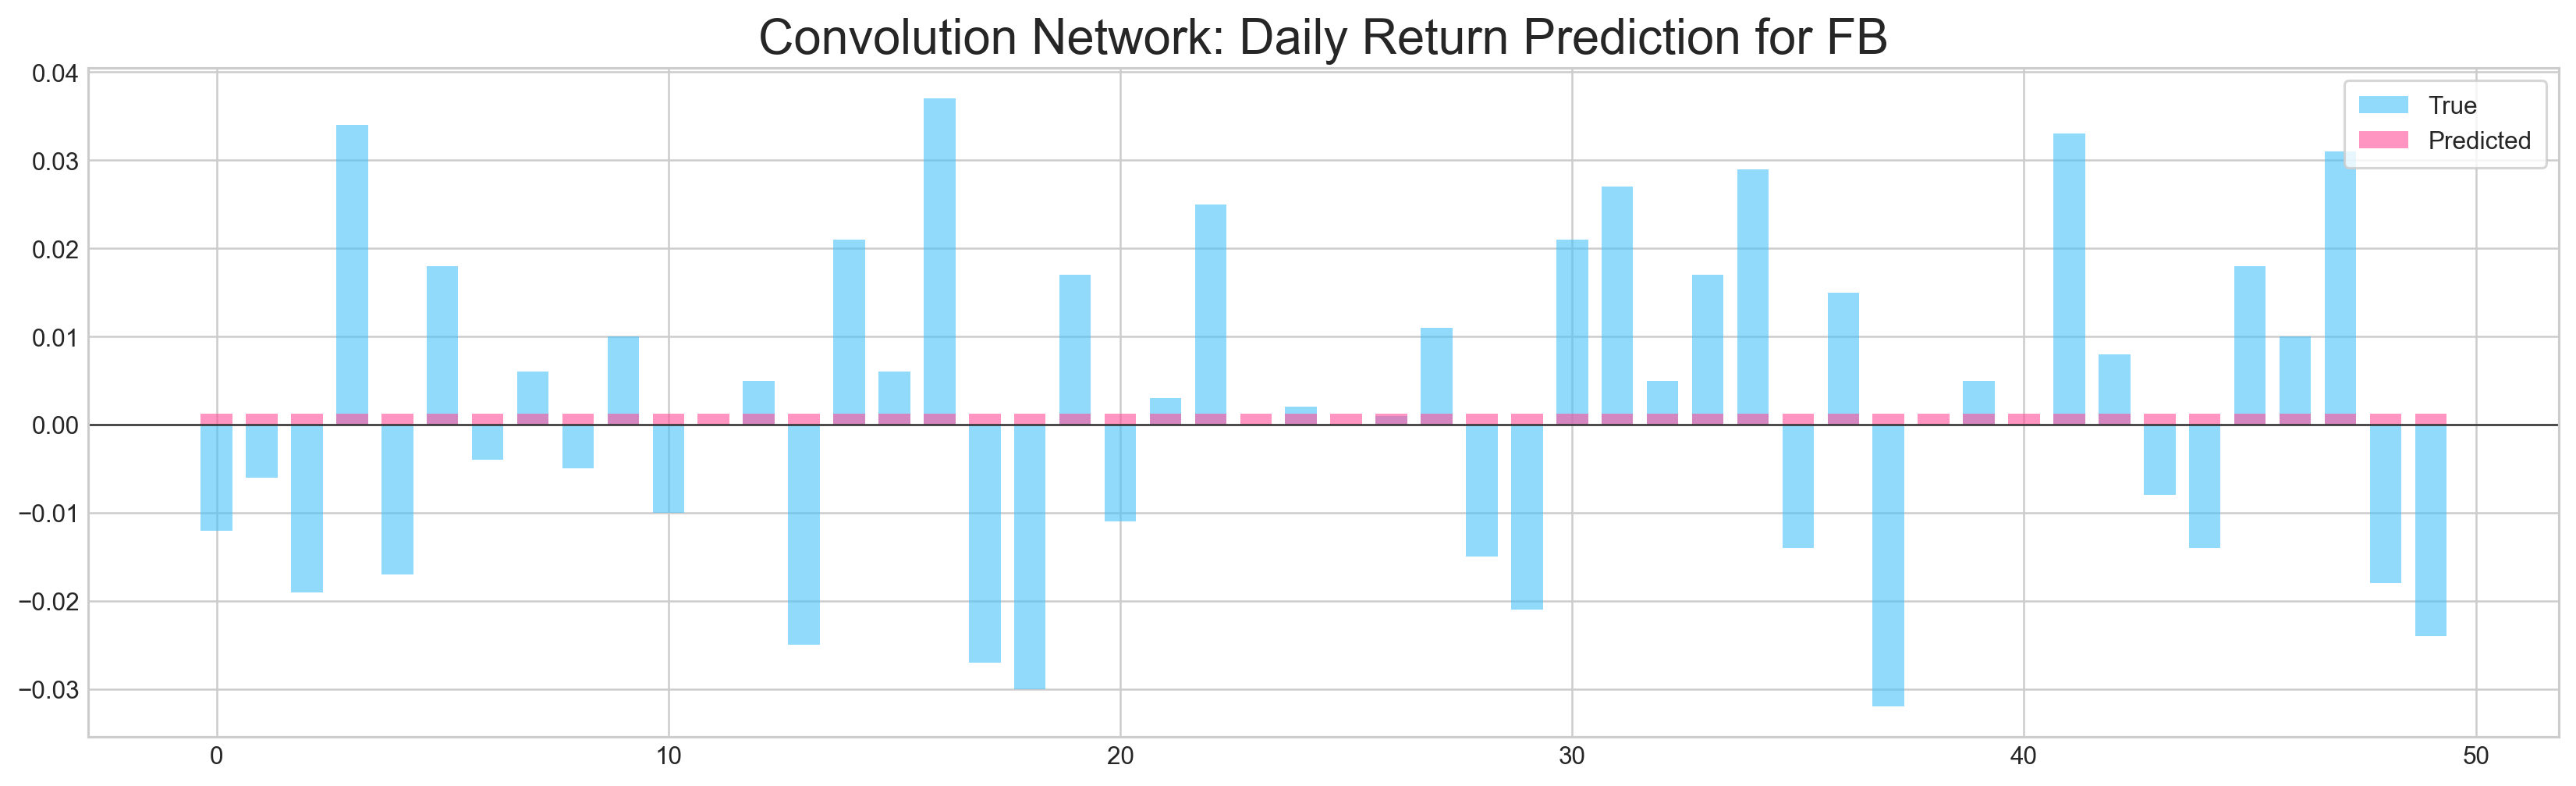

MSE:  0.0003172249663907084
Accuracy: 52.0%


In [41]:
pred, y_true, y_pred = evaluation(X_test, y_test, model, random=False, n_preds=50, show_graph=True)

---
# Combined Securities: Combine Data, Clean and Scale
---

In [53]:
all_stocks = pd.concat(stocks,ignore_index=True)
all_stocks.isna().sum()

High            0
Low             0
Open            0
Close           0
Volume          0
Adj Close       0
Return          0
Change          0
Volatility      5
MA7            30
MA21          100
Momentum       15
RSI            70
MACD            0
Signal          0
Upper_Band    100
Lower_Band    100
dtype: int64

In [54]:
all_stocks.dropna(inplace=True)

print('No Missing Data') if sum(scaled_ticker.isna().sum())==0 else scaled_ticker.isna().sum()

No Missing Data


In [55]:
def split_sequences(features, target, n_steps, split=True, ratio=0.8):
    X, y = [],[]
    
    for i in range(len(features)):
        end_index = i + n_steps
        if end_index > len(features): 
            break
        seq_x, seq_y = features[i:end_index], target[end_index-1]
        X.append(seq_x)
        y.append(seq_y)
    
    if split==True:
        X_train = np.array(X[:round(len(X)*ratio)])
        y_train = np.array(y[:round(len(X)*ratio)])
        X_test = np.array(X[round(len(X)*ratio):])
        y_test = np.array(y[round(len(X)*ratio):])
        return X_train, y_train, X_test, y_test
    else: 
        return np.array(X), np.array(y)

In [56]:
all_scaled = scale(all_stocks, scale=(0,1))

n_steps = 21
X_train, y_train, X_test, y_test = split_sequences(
                                    all_scaled.to_numpy()[:-1], 
                                    all_stocks['Return'].shift(-1).to_numpy()[:-1], n_steps, split=True, ratio=0.8)

---
# Combined Securities: Training Process 
---

In [57]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=500, kernel_size=10, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 500)           85500     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 500)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 500)               250500    
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                        

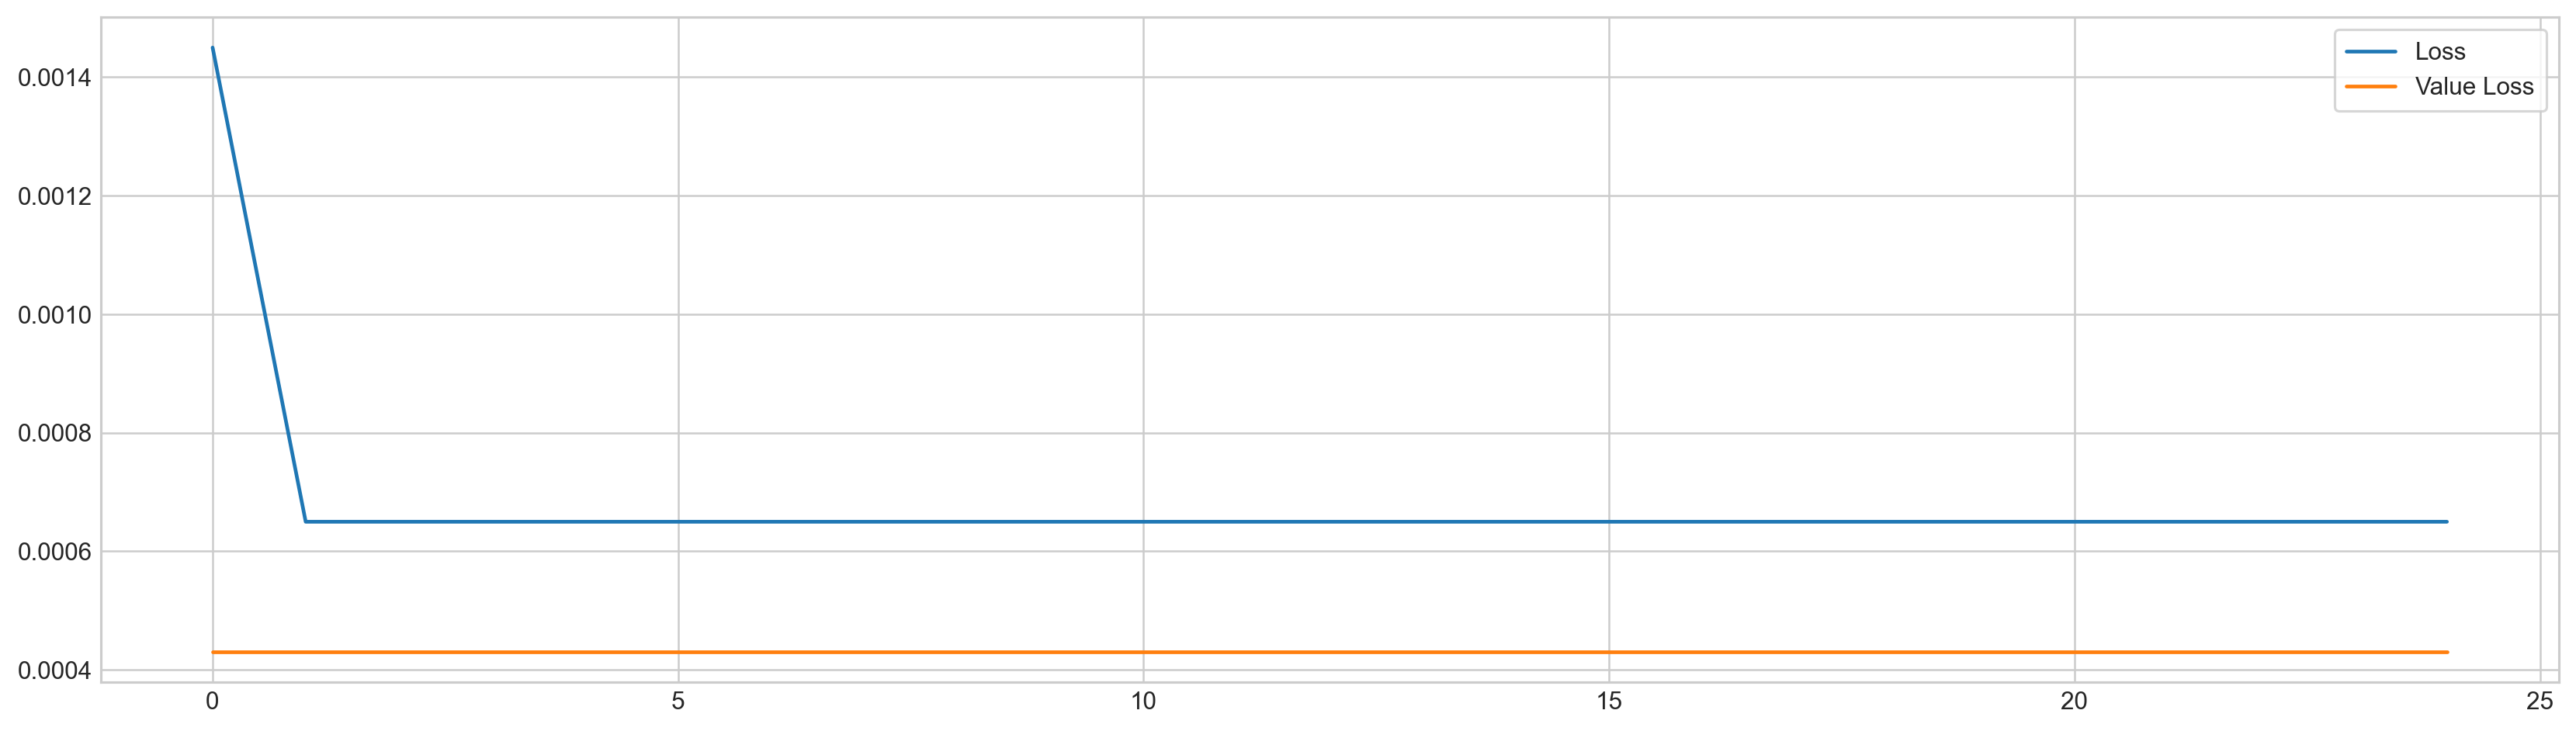

In [59]:
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))

plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1, borderpad=.5)
plt.show()

---
# Combined Securities: Daily Return Prediction 
---

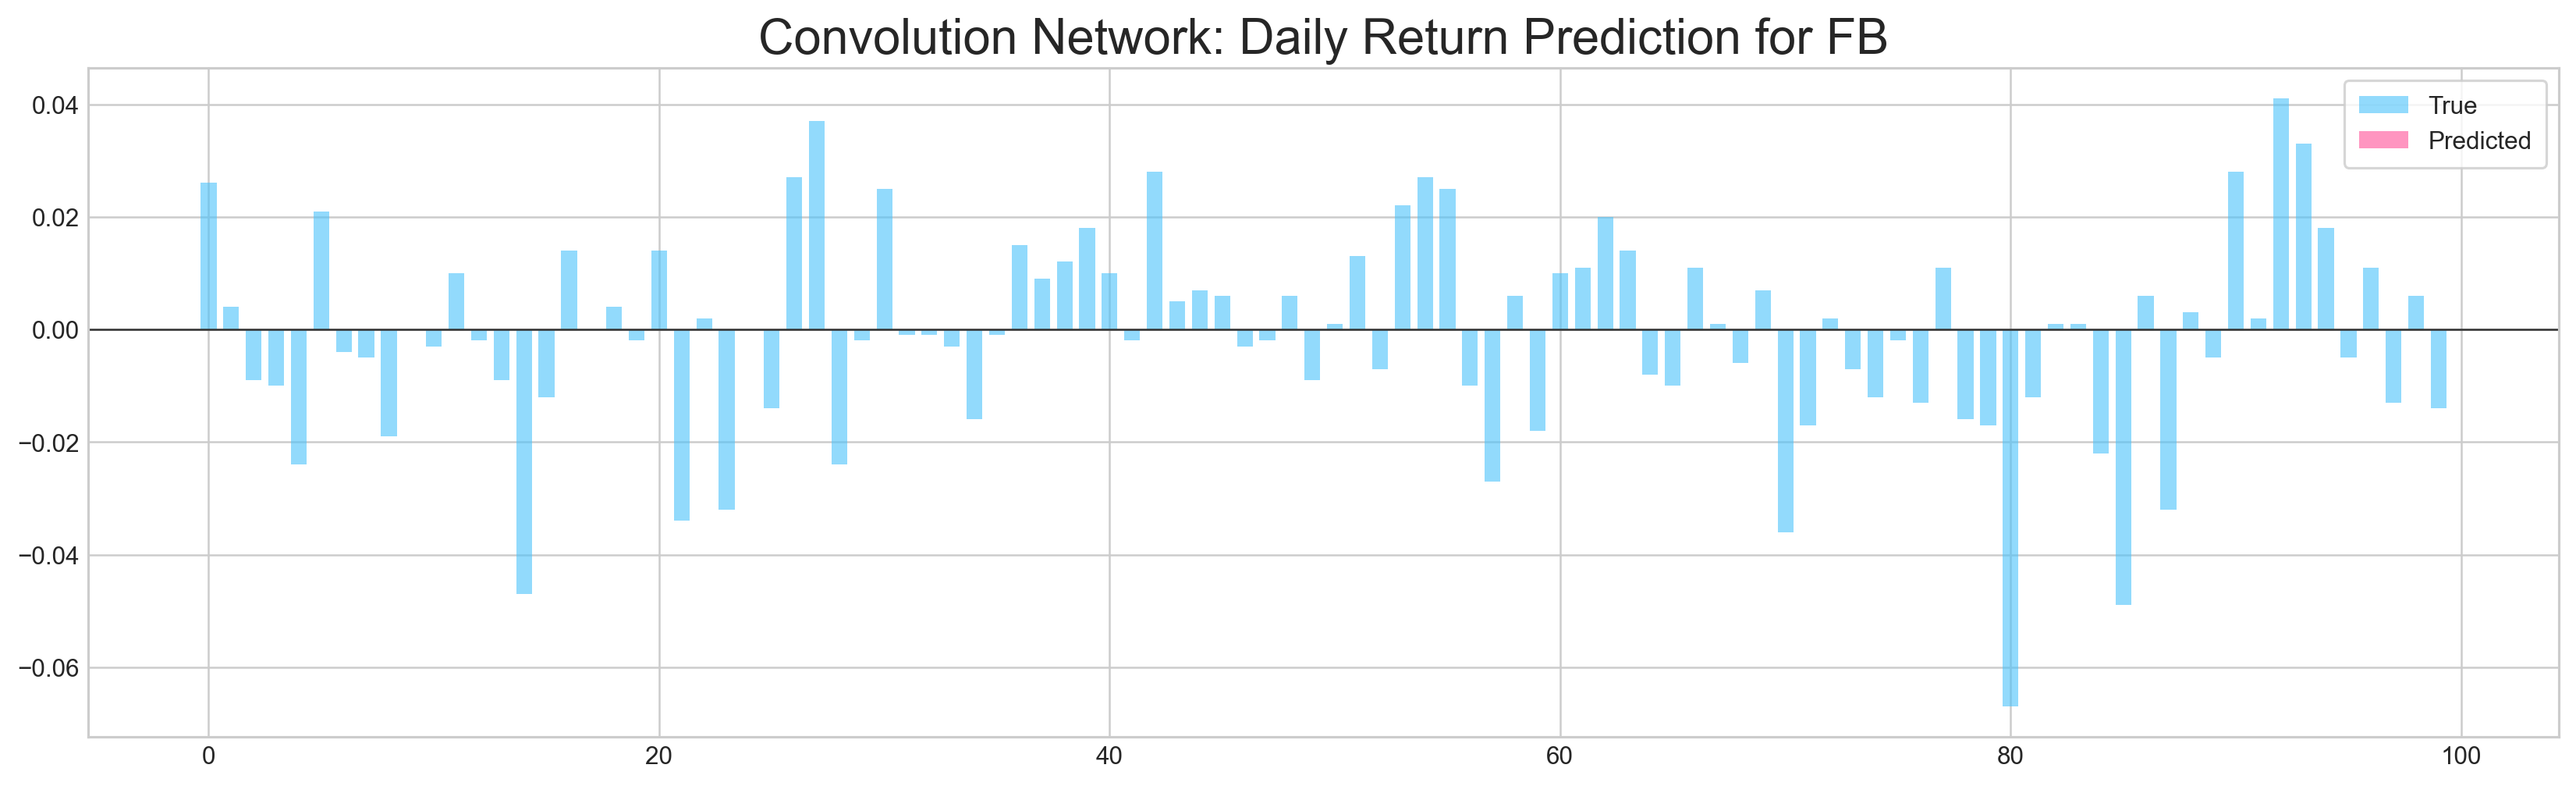

MSE:  0.00033202001863959045
Accuracy: 47.0%


In [60]:
pred, y_true, y_pred = evaluation(
                        X_test, y_test, model, random=True, n_preds=100, show_graph=True)

---
# Bayesian Optimization: Import, Clean, and Scale Data
---

In [67]:
n_steps = 21
scaled_ticker = scale(stocks[ticker.lower()], scale = (0,1))

scaled_ticker.isna().sum()

High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
Return         0
Change         0
Volatility     1
MA7            6
MA21          20
Momentum       3
RSI           14
MACD           0
Signal         0
Upper_Band    20
Lower_Band    20
dtype: int64

In [68]:
scaled_ticker.dropna(inplace=True)

print('No Missing Data') if sum(scaled_ticker.isna().sum())==0 else scaled_ticker.isna().sum()

No Missing Data


In [69]:
X_train, y_train, X_test, y_test = split_sequences(
            scaled_ticker.to_numpy()[:-1],
            stocks[ticker.lower()].Return.shift(-1).to_numpy()[:-1],
            n_steps,
            split=True,
            ratio=0.8
)            

---
# Bayesian Optimization: Build Model
---

In [70]:
def bayesian_model(d1, d2, filters, pool, kernel):
    keras.backend.clear_session()
    
    d1, d2 = int(d1), int(d2)
    filters, kernel, pool = int(filters), int(kernel), int(pool)
    
    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]
    
    model = Sequential()
    
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(d2, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train, y_train, epochs=4, verbose=0, validation_data=[X_test,y_test], use_multiprocessing=True)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [71]:
def bayesian_optimization():
    
    pbounds = {
        'filters': (1,10),
        'd1': (16,250),
        'd2': (10,40),
        'kernel': (2,10),
        'pool': (2,10)
    }
    optimizer = BayesianOptimization(
                f = bayesian_model, 
                pbounds = pbounds,
                random_state = 1, 
                verbose = 2 
    )
    optimizer.maximize(init_points=5, n_iter=5)
    print(optimizer.max)

In [72]:
bayesian_optimization()

|   iter    |  target   |    d1     |    d2     |  filters  |  kernel   |   pool    |
-------------------------------------------------------------------------------------
|  1        |  0.000331 |  113.6    |  31.61    |  1.001    |  4.419    |  3.174    |
|  2        |  0.000482 |  37.61    |  15.59    |  4.11     |  5.174    |  6.311    |
|  3        |  0.000271 |  114.1    |  30.56    |  2.84     |  9.025    |  2.219    |
|  4        |  0.000332 |  172.9    |  22.52    |  6.028    |  3.123    |  3.585    |
|  5        |  0.000326 |  203.4    |  39.05    |  3.821    |  7.539    |  9.011    |
|  6        |  0.000382 |  36.64    |  19.83    |  3.085    |  7.986    |  6.861    |
|  7        |  0.000372 |  38.63    |  14.33    |  2.469    |  3.396    |  4.151    |
|  8        |  0.000351 |  38.23    |  15.65    |  2.713    |  6.233    |  7.134    |
|  9        |  0.000429 |  106.9    |  37.77    |  8.639    |  6.692    |  3.755    |
|  10       |  0.000385 |  34.93    |  35.5     |  8.2

---
# Bayesian Optimization: Training Process
---

In [73]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

keras.backend.clear_session()

model = Sequential()

model.add(Conv1D(filters=9, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=9))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

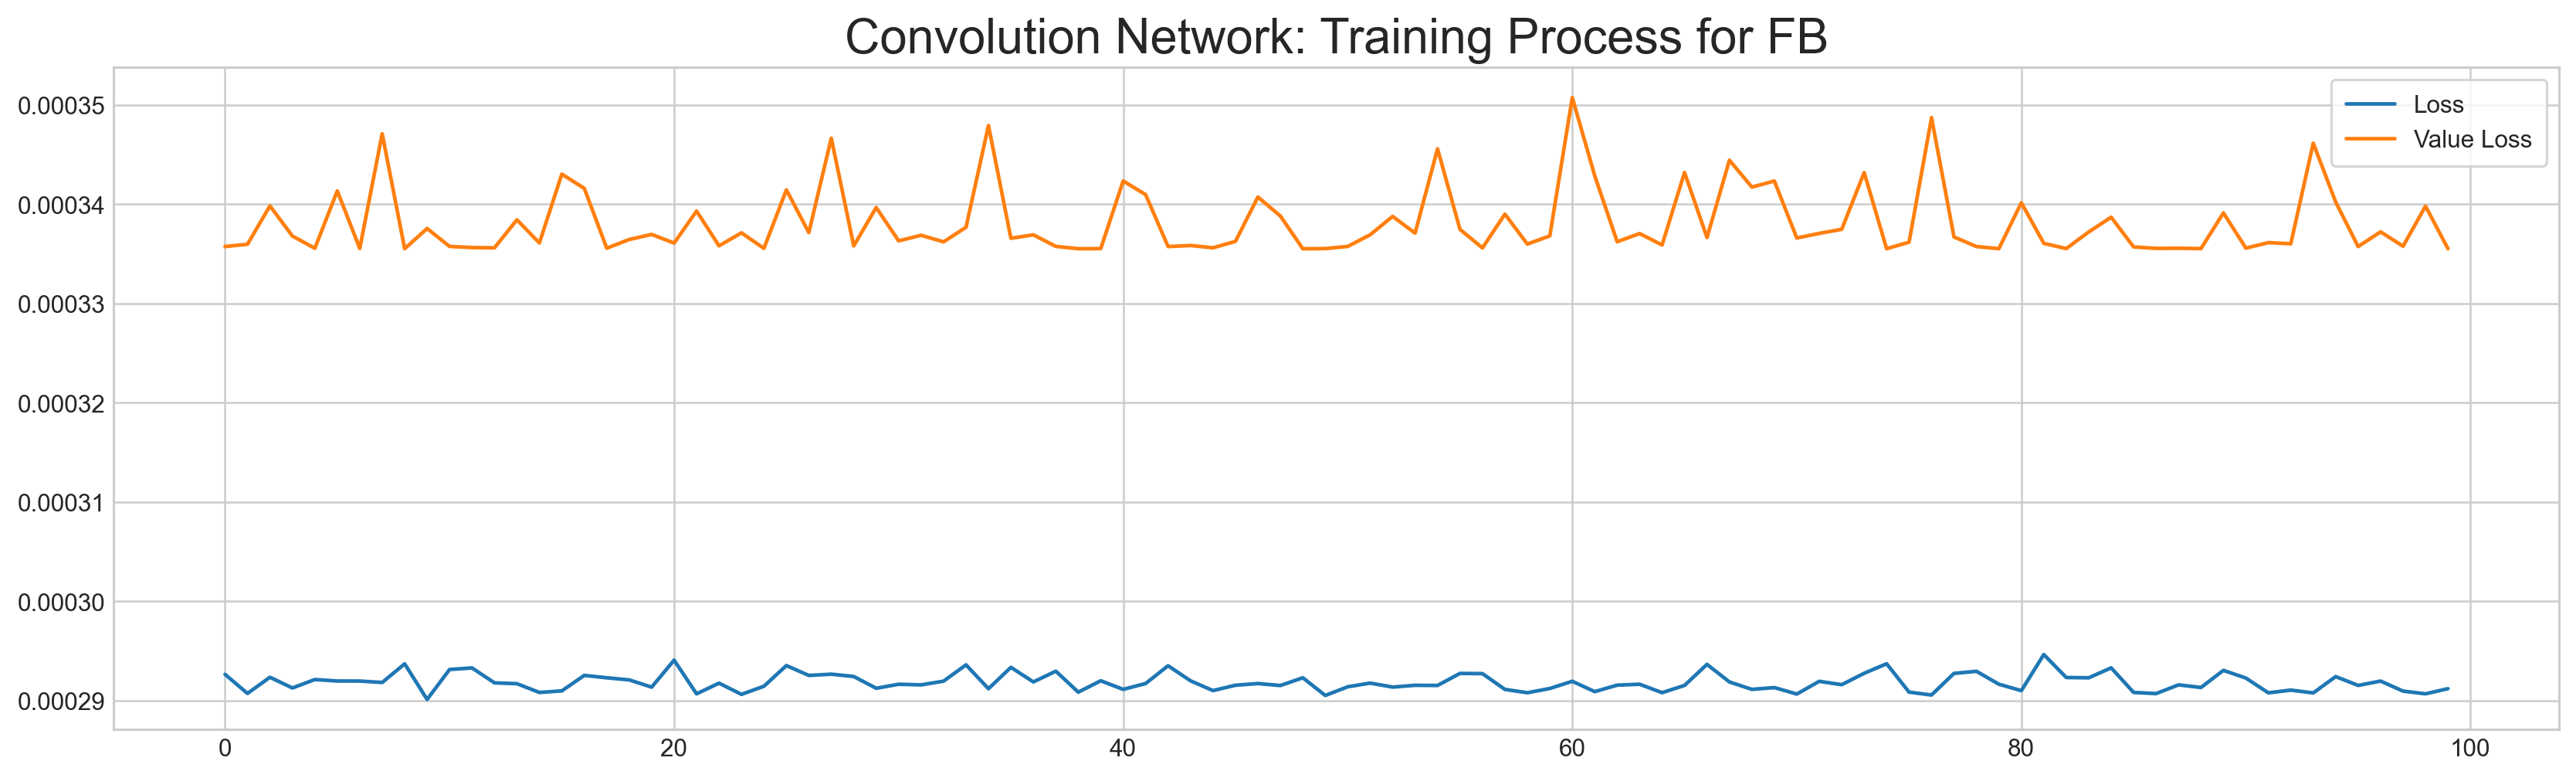

In [74]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))

plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label="Value Loss")

plt.title("Convolution Network: Training Process for "+ticker.upper(), fontsize=20)
plt.legend(frameon=True, loc=1, borderpad=.6)
plt.show()

---
# Bayesian Optimization: Daily Return Prediction 
---

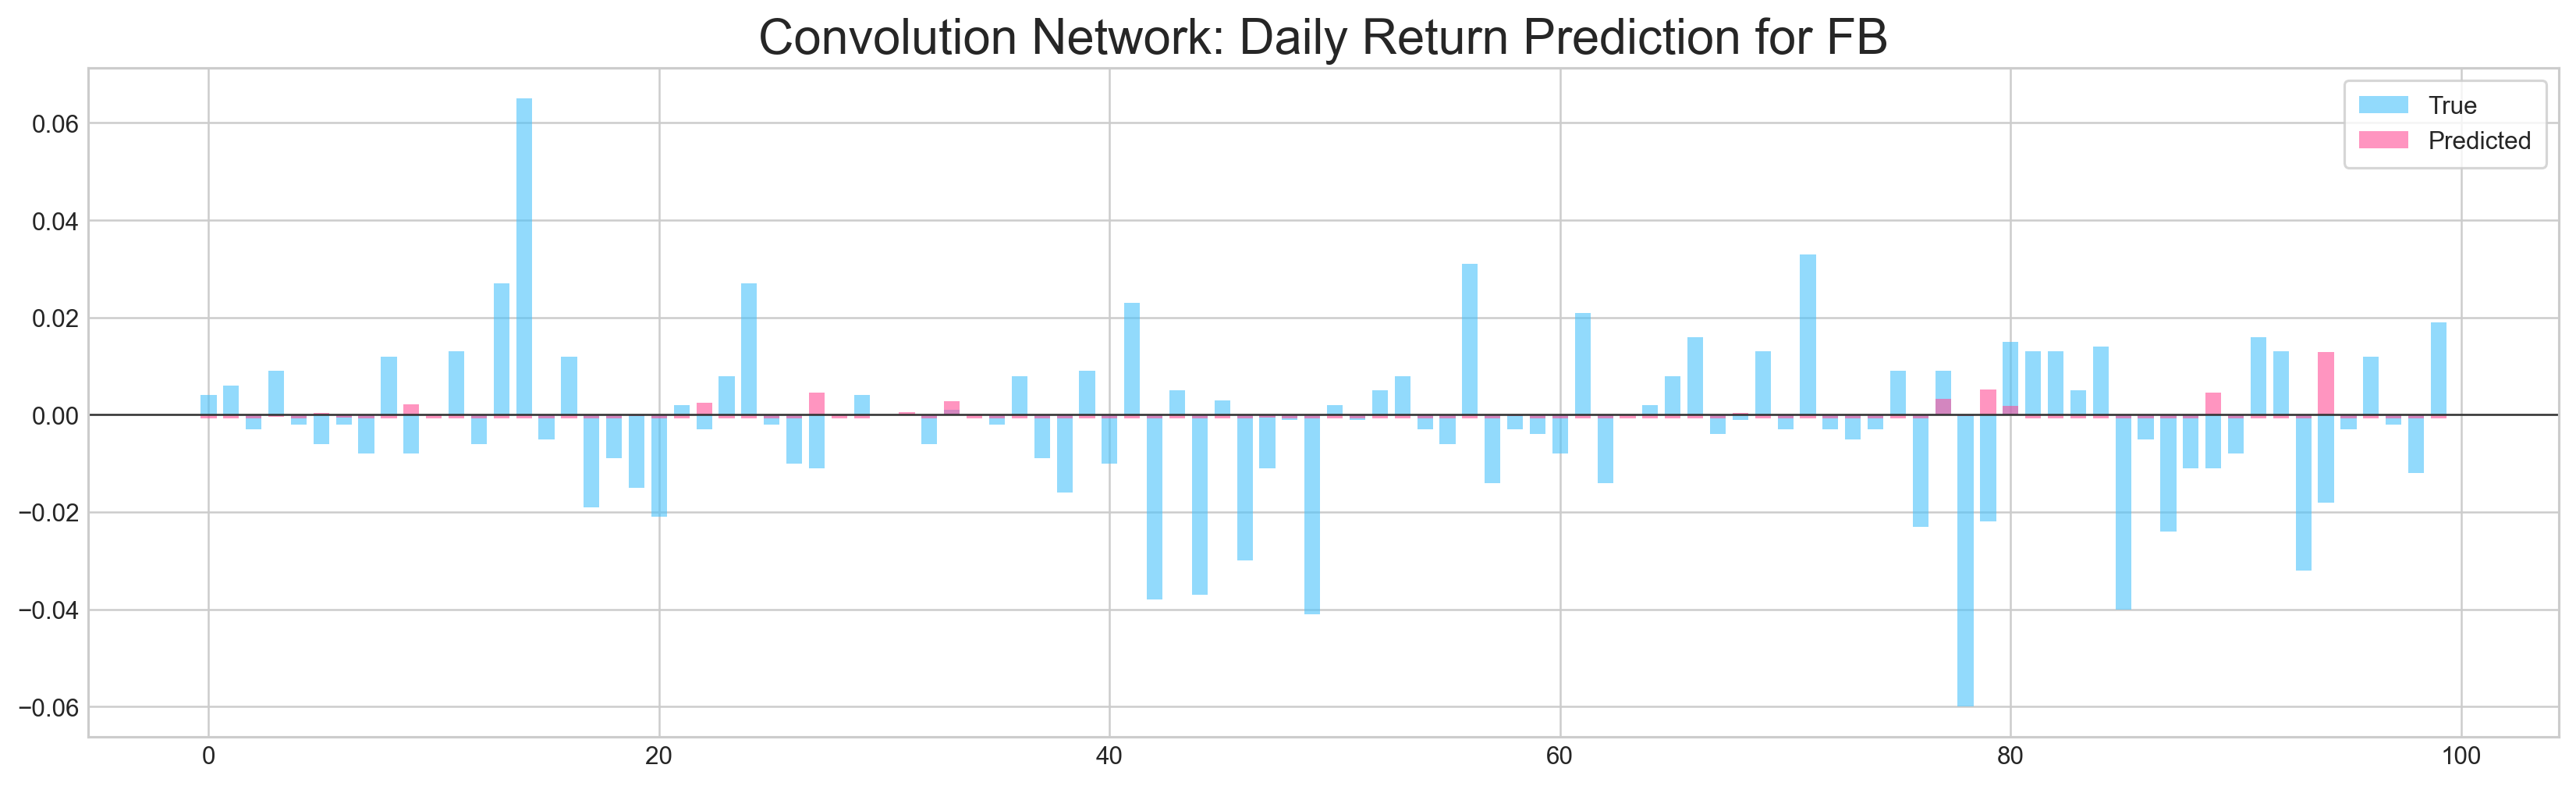

MSE:  0.0002988616955705214
Accuracy: 50.0%


In [75]:
pred, y_true, y_pred = evaluation(X_test, y_test, model, random=True, n_preds=100, show_graph=True)